In [3]:
import pandas as pd
from ipywidgets import widgets

In [4]:
data = pd.read_excel('verbali-esami.xls')
data.iloc[:10,3:8]

,Descrizione insegnamento,Cfu,Voto,Stato Esito,Data
0,PROGRAMMAZIONE II,6,19,Rifiutato,2021-02-24
1,PROGRAMMAZIONE II,6,20,Verbalizzato,2021-02-24
2,PROGRAMMAZIONE II,6,27,Verbalizzato,2021-02-24
3,PROGRAMMAZIONE II,6,20,Verbalizzato,2021-02-24
4,PROGRAMMAZIONE II,6,Respinto,Verbalizzato,2021-02-24
5,PROGRAMMAZIONE II,6,26,Verbalizzato,2021-02-24
6,PROGRAMMAZIONE II,6,20,Verbalizzato,2021-02-24
7,PROGRAMMAZIONE II,6,Ritirato,Verbalizzato,2021-02-23
8,PROGRAMMAZIONE II,6,Ritirato,Verbalizzato,2021-02-23
9,PROGRAMMAZIONE II,6,21,Verbalizzato,2021-02-23


In [124]:
insegnamenti = sorted(frozenset(data['Descrizione insegnamento']))
appelli = lambda insegnamento: sorted(frozenset(data[data['Descrizione insegnamento'] == insegnamento].Data.dt.date))
verbali = lambda insegnamento, appello: data[(data['Descrizione insegnamento'] == insegnamento) & (data.Data.dt.date == appello)]
starts_with_digit = lambda _: _[0] in frozenset('0123456789')
ends_with_digit = lambda _: _[-1] in frozenset('0123456789')
perc = lambda _: (10000*_/sum(_)).astype(int)/100
def hist(_):
    perc(_.value_counts()).sort_index().plot.bar()
count = lambda _: pd.DataFrame(_.value_counts().sort_index()).T

In [125]:
wins = widgets.Select(description = 'Insegnamenti')
wdate = widgets.SelectMultiple(description = 'Date')
wlabel = widgets.HTML(description = 'Selezione')

def uwdate(change):
    wdate.options = appelli(change.new)
    wdate.value = wdate.options
wins.observe(uwdate, names = 'value')

def uselected(change):
    global selected
    selected = data[(data['Descrizione insegnamento'] == wins.value) & (data.Data.dt.date.isin(wdate.value))]
    wlabel.value = "<b>Verbali</b>: {}<br/><b>Iscritti</b>: {}".format(len(selected), len(set(selected.Matricola)))
        
wdate.observe(uselected, names = 'value')    

wins.options = insegnamenti
wins.value = insegnamenti[0]
wdate.options = wdate.value = appelli(insegnamenti[0])

widgets.HBox([wins, wdate, wlabel])

In [126]:
esiti = selected.sort_values('Data').apply(
    lambda r: pd.Series({'Matricola': r.Matricola, 'Esito': ('~' + r.Voto if r['Stato Esito'] == 'Rifiutato' else r.Voto)}), axis = 1
)[['Matricola', 'Esito']]

esiti.head()

,Matricola,Esito
326,923197,Respinto
296,923353,18
297,934765,24
298,933671,Respinto
299,930814,~18


In [127]:
def euniq(e):
    v = list(filter(starts_with_digit, e.values))
    if v: return v[0]
    v = list(filter(ends_with_digit, e.values))
    if v: return max(v)
    if 'Respinto' in e.values: return 'RE'
    if 'Ritirato' in e.values: return 'RI'

esiti_unici = esiti.groupby('Matricola').agg(euniq).Esito

esiti_unici.head()

Matricola
903870    RE
917221    RE
922686    RE
922688    25
922714    18
Name: Esito, dtype: object

In [128]:
esiti_unici_sempl = esiti_unici.apply(
    lambda _: 'OK' if starts_with_digit(_) else ('~' if _[0] == '~' else _)
)

esiti_unici_promossi = esiti_unici[esiti_unici.apply(starts_with_digit)].apply(
    lambda _: 33 if _ == '30 e lode' else int(_)
)

In [129]:
count(esiti_unici)

,18,19,20,21,22,23,24,25,26,27,28,30,30 e lode,RE,RI,~19
Esito,9,6,8,4,5,3,4,2,2,2,6,4,1,56,23,1


In [130]:
count(esiti_unici_sempl)

,OK,RE,RI,~
Esito,56,56,23,1


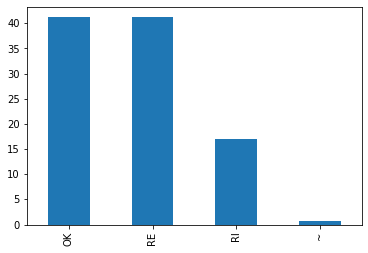

In [131]:
hist(esiti_unici_sempl)

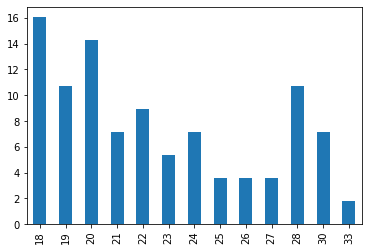

In [132]:
hist(esiti_unici_promossi)

In [133]:
def emerge(e):
    res = []
    for v in e.values:
        if starts_with_digit(v) or ends_with_digit(v): res.append(v)
        if v == 'Respinto': res.append('RE')
        if v == 'Ritirato': res.append('RI')
    return tuple(res)

patterns = esiti.groupby('Matricola').agg(emerge)

patterns.head()

,Esito
Matricola,
903870,"(RE,)"
917221,"(RE, RE)"
922686,"(RI, RI, RI, RI, RI, RI, RE)"
922688,"(RE, ~18, 25)"
922714,"(18,)"


In [134]:
def emerge_sempl(e):
    res = []
    for v in e.values:
        if starts_with_digit(v): res.append('OK')
        if v[0] == '~': res.append('~')
        if v == 'Respinto': res.append('RE')
        if v == 'Ritirato': res.append('RI')
    return tuple(res)

patterns_sempl = esiti.groupby('Matricola').agg(emerge_sempl)

patterns_sempl.head()

,Esito
Matricola,
903870,"(RE,)"
917221,"(RE, RE)"
922686,"(RI, RI, RI, RI, RI, RI, RE)"
922688,"(RE, ~, OK)"
922714,"(OK,)"


In [135]:
patterns_len = patterns[patterns.Esito.apply(lambda _: starts_with_digit(_[-1]))].Esito.apply(len)

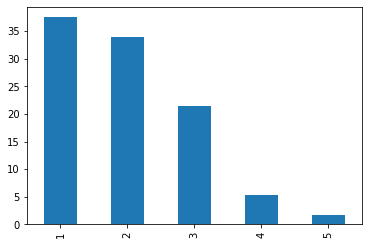

In [136]:
hist(patterns_len)

In [137]:
patterns_sempl.Esito.apply(' '.join).value_counts(ascending = True)#.plot.barh(figsize=(8,10))

RE RE RE RE RE           1
RI RI OK                 1
RI RE ~                  1
RI ~ RE RE OK            1
RE RI OK                 1
RE RI RI RI RE RE        1
RI RI RI                 1
RI RE RI                 1
RI RI RE RE RE           1
RI RE RE OK              1
RE RI RE RI              1
~ RE OK                  1
RE RI RE RE              1
RE ~ OK                  1
RI RI RI RI RI RI RE     1
RE RE RE OK              2
RI RI RE                 2
~ OK                     2
RE RI                    4
RI RE                    5
RI OK                    5
RI RE RE                 5
RE RE RE                 6
RE RE OK                 8
RE RE                    9
RI RI                    9
RE OK                   12
RI                      13
RE                      18
OK                      21
Name: Esito, dtype: int64